In [1]:
import os
import glob
import math
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show_hist
from scipy.spatial import distance
import os
import glob
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import rasterio

# Vizualizing Lat, Long, Alt, Off-Nadir and Azimuth Distribution of all views of one scene

Found 19 RGB images

Results (sorted by filename):
----------------------------------------------------------------------------------------------------
File Name            Latitude   Longitude    Off-Nadir  Azimuth    Camera X   Camera Y   Camera Z  
----------------------------------------------------------------------------------------------------
JAX_068_001_RGB.tif  30.299200  -81.639700   22.09      249.68     -190340.84 -70500.72  500000.00 
JAX_068_002_RGB.tif  30.299400  -81.639700   15.29      244.67     -123537.92 -58478.86  500000.00 
JAX_068_003_RGB.tif  30.300700  -81.639600   19.98      225.28     -129184.41 -127916.38 500000.00 
JAX_068_004_RGB.tif  30.299600  -81.640300   9.12       92.35      80188.27   -3291.30   500000.00 
JAX_068_005_RGB.tif  30.299800  -81.640800   19.06      250.69     -163060.28 -57149.45  500000.00 
JAX_068_006_RGB.tif  30.300300  -81.640800   16.66      314.36     -106961.41 104606.19  500000.00 
JAX_068_007_RGB.tif  30.299900  -81.640200   13

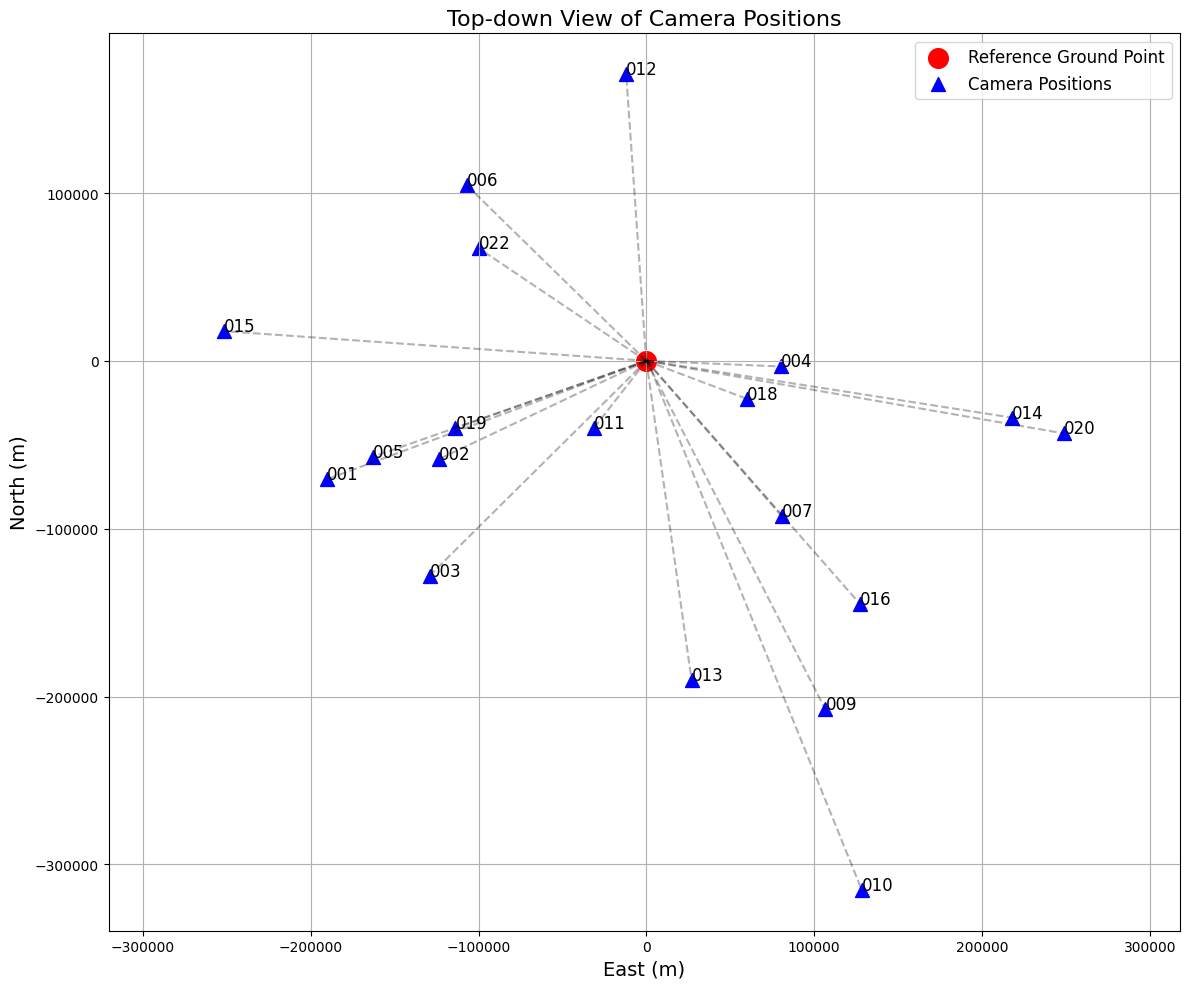

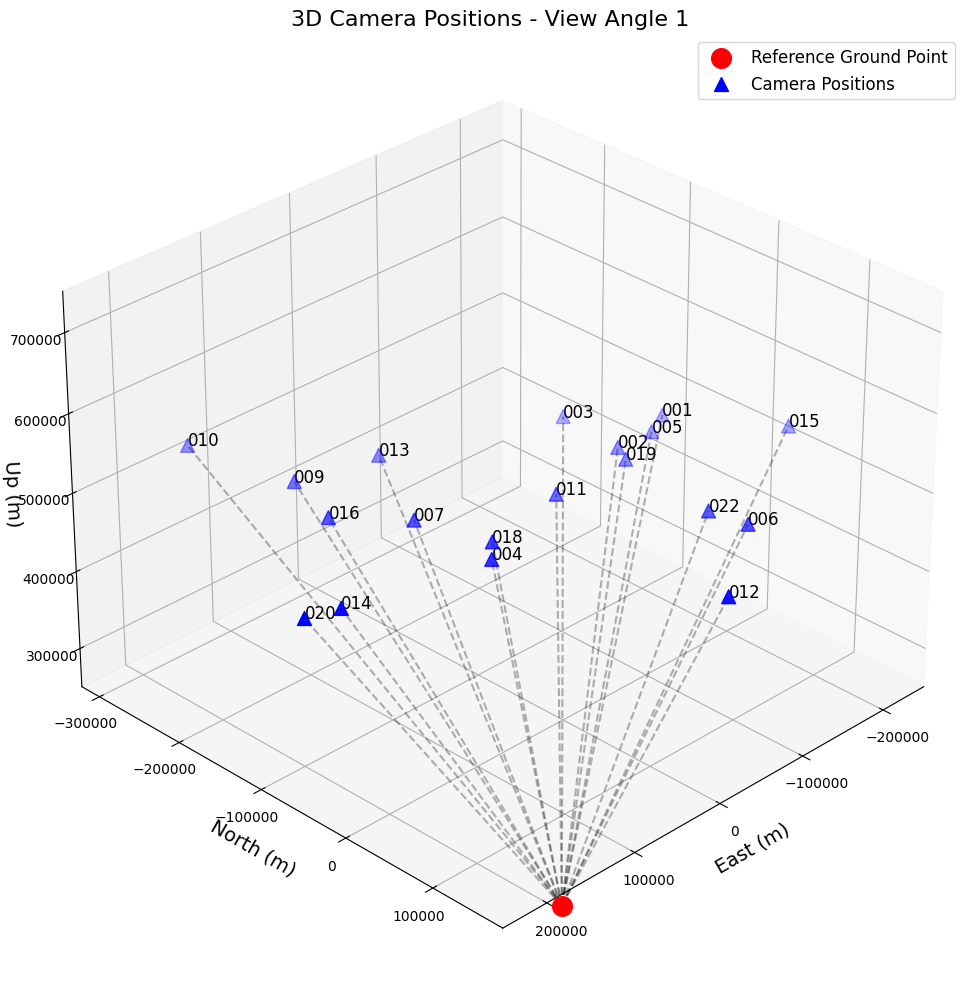

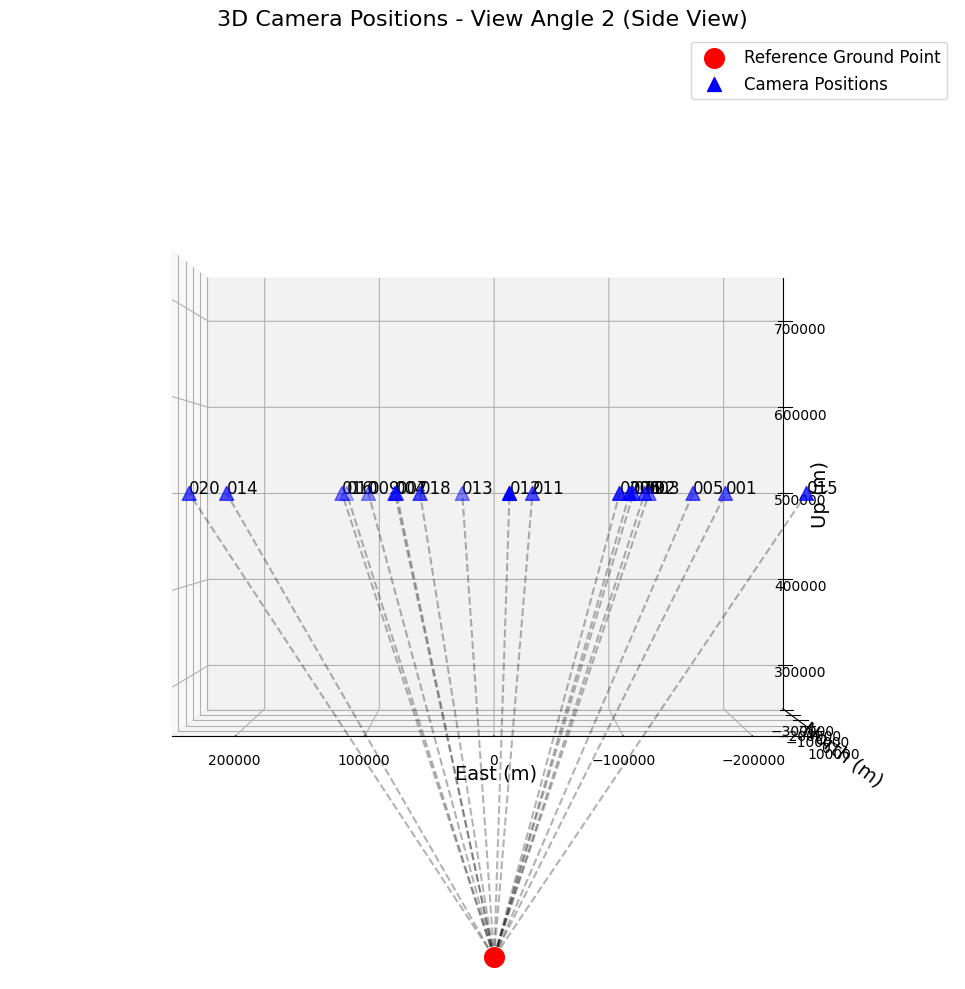

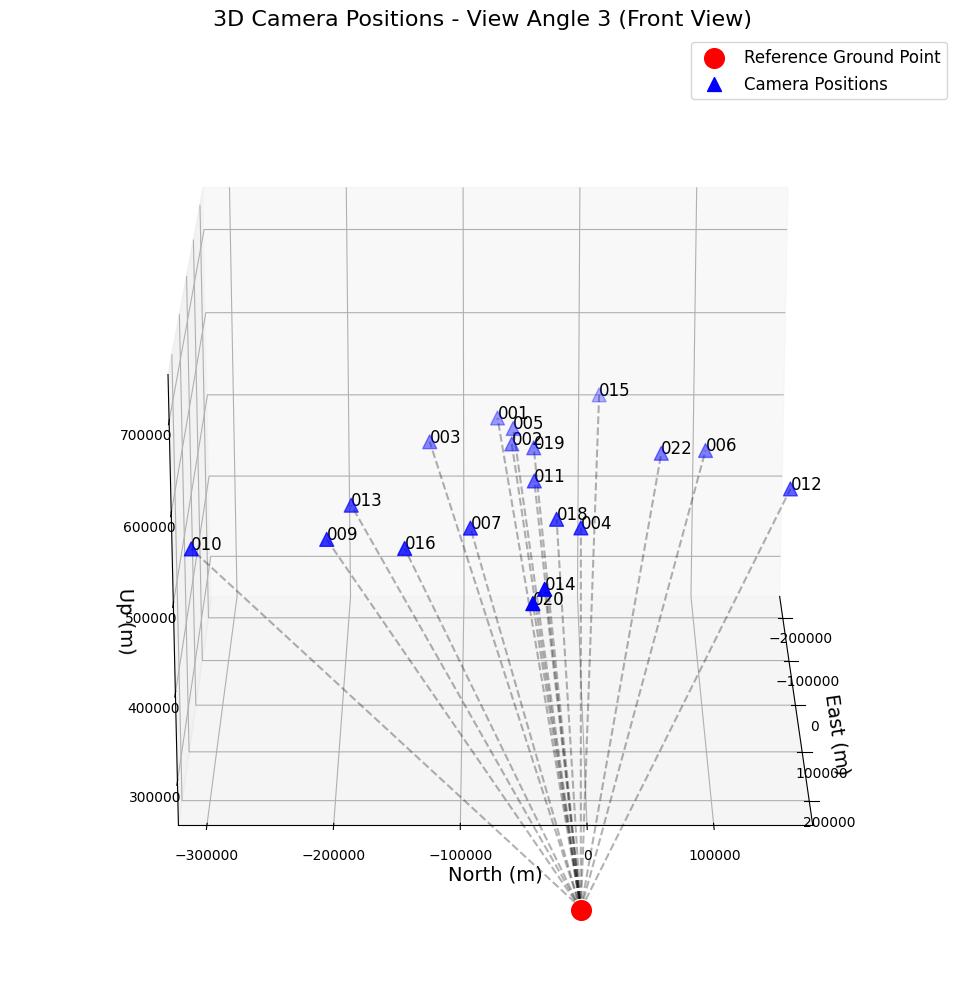


Camera positions exported to camera_positions.txt


In [4]:
import os
import glob
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import rasterio

def extract_rpc_data(tif_path):
    """Extract RPC data from rgb TIF file"""
    with rasterio.open(tif_path) as src:
        # Get RPC data
        rpc_data = {}
        try:
            # Check if there are RPC tags
            if 'RPC' in src.tag_namespaces():
                rpc_tags = src.tags(ns='RPC')
                
                # Extract all RPC parameters
                rpc_data["LAT_OFF"] = float(rpc_tags.get("LAT_OFF", 0))
                rpc_data["LONG_OFF"] = float(rpc_tags.get("LONG_OFF", 0))
                rpc_data["HEIGHT_OFF"] = float(rpc_tags.get("HEIGHT_OFF", 0))
                rpc_data["LAT_SCALE"] = float(rpc_tags.get("LAT_SCALE", 1))
                rpc_data["LONG_SCALE"] = float(rpc_tags.get("LONG_SCALE", 1))
                rpc_data["HEIGHT_SCALE"] = float(rpc_tags.get("HEIGHT_SCALE", 1))
                rpc_data["LINE_OFF"] = float(rpc_tags.get("LINE_OFF", 0))
                rpc_data["SAMP_OFF"] = float(rpc_tags.get("SAMP_OFF", 0))
                rpc_data["LINE_SCALE"] = float(rpc_tags.get("LINE_SCALE", 1))
                rpc_data["SAMP_SCALE"] = float(rpc_tags.get("SAMP_SCALE", 1))
                
                # Parse coefficient arrays
                for coef in ["LINE_NUM_COEFF", "LINE_DEN_COEFF", "SAMP_NUM_COEFF", "SAMP_DEN_COEFF"]:
                    if coef in rpc_tags:
                        # Parse the coefficients from space-separated string
                        rpc_data[coef] = [float(val) for val in rpc_tags[coef].split()]
        except Exception as e:
            print(f"Error extracting RPC data from {os.path.basename(tif_path)}: {e}")
            return None
        
        return rpc_data

def calculate_viewing_angles(rpc_data):
    """Calculate approximate satellite viewing angles from RPC data"""
    if not rpc_data:
        return None, None
    
    # Extract first-order coefficients for height
    try:
        line_z_coef = rpc_data["LINE_NUM_COEFF"][3]  # Coefficient for Z
        samp_z_coef = rpc_data["SAMP_NUM_COEFF"][3]  # Coefficient for Z
        
        # Estimate off-nadir angle
        gradient_magnitude = math.sqrt(line_z_coef**2 + samp_z_coef**2)
        off_nadir_angle = math.atan(gradient_magnitude) * (180/math.pi) * 15
        off_nadir_angle = min(45, max(0, off_nadir_angle))
        
        # Estimate azimuth angle
        azimuth = math.atan2(samp_z_coef, line_z_coef) * (180/math.pi)
        if azimuth < 0:
            azimuth += 360
            
        return off_nadir_angle, azimuth
    except (KeyError, IndexError) as e:
        print(f"Error calculating viewing angles: {e}")
        return None, None

def estimate_camera_position(lat, lon, alt, off_nadir, azimuth, satellite_height=500000):
    """
    Estimate the camera position in 3D space
    
    Args:
        lat, lon, alt: The ground point location (degrees, degrees, meters)
        off_nadir: Off-nadir angle in degrees
        azimuth: Azimuth angle in degrees
        satellite_height: Approximate satellite height in meters
    
    Returns:
        tuple: (camera_x, camera_y, camera_z) in meters in local ENU coordinates
    """
    # Convert ground point to a local East-North-Up (ENU) coordinate system
    # For simplicity, we'll use (0,0,0) as our local origin
    
    # Calculate slant range (distance from ground to satellite)
    # assuming a typical satellite height
    slant_range = satellite_height / math.cos(math.radians(off_nadir))
    
    # Convert azimuth and off-nadir to 3D vector
    # Azimuth is measured clockwise from North
    # Off-nadir is measured from the vertical
    
    # Calculate direction vector components
    # X is East, Y is North, Z is Up
    x = slant_range * math.sin(math.radians(off_nadir)) * math.sin(math.radians(azimuth))
    y = slant_range * math.sin(math.radians(off_nadir)) * math.cos(math.radians(azimuth))
    z = slant_range * math.cos(math.radians(off_nadir))
    
    return (x, y, z)

def latlon_to_xyz(lat, lon, alt=0, ref_lat=None, ref_lon=None):
    """
    Convert latitude, longitude to local ENU coordinates using a simpler approach
    
    Args:
        lat, lon: Point coordinates (degrees)
        alt: Altitude in meters
        ref_lat, ref_lon: Reference point (degrees), if None will use the input point
    
    Returns:
        tuple: (x, y, z) in meters in local ENU coordinates
    """
    # If no reference point specified, use the input point
    if ref_lat is None:
        ref_lat = lat
    if ref_lon is None:
        ref_lon = lon
    
    # Earth radius in meters
    R = 6378137.0
    
    # Convert to radians
    lat_rad = math.radians(lat)
    lon_rad = math.radians(lon)
    ref_lat_rad = math.radians(ref_lat)
    ref_lon_rad = math.radians(ref_lon)
    
    # Calculate distance in east direction (x)
    x = R * math.cos(ref_lat_rad) * (lon_rad - ref_lon_rad)
    
    # Calculate distance in north direction (y)
    y = R * (lat_rad - ref_lat_rad)
    
    # Z is just the altitude (relative to reference altitude)
    z = alt
    
    return (x, y, z)

def process_multiple_images(folder_path, pattern):
    """Process multiple RGB images to extract location, viewing angles, and camera positions"""
    # Find all matching files
    rgb_files = glob.glob(os.path.join(folder_path, pattern))
    
    if not rgb_files:
        print(f"No files matching pattern '{pattern}' found in {folder_path}")
        return
    
    print(f"Found {len(rgb_files)} RGB images")
    
    # Create a table for results
    results = []
    
    # Process each image
    for rgb_file in rgb_files:
        file_name = os.path.basename(rgb_file)
        
        # Extract RPC data
        rpc_data = extract_rpc_data(rgb_file)
        
        if rpc_data:
            # Get location
            lat = rpc_data.get("LAT_OFF")
            lon = rpc_data.get("LONG_OFF")
            alt = rpc_data.get("HEIGHT_OFF")
            
            # Calculate viewing angles
            off_nadir, azimuth = calculate_viewing_angles(rpc_data)
            
            # Add to results
            results.append({
                "file_name": file_name,
                "latitude": lat,
                "longitude": lon,
                "altitude": alt,
                "off_nadir_angle": off_nadir,
                "azimuth": azimuth,
                "google_maps_format": f"{lat}, {lon}"
            })
        else:
            print(f"Could not extract RPC data from {file_name}")
    
    # Sort results by filename
    results.sort(key=lambda x: x['file_name'])
    
    # Calculate reference point (first image)
    ref_lat = results[0]['latitude']
    ref_lon = results[0]['longitude']
    ref_alt = results[0]['altitude']
    
    # Add camera positions
    for r in results:
        # Estimate camera position in the sky relative to the ground point
        cam_x, cam_y, cam_z = estimate_camera_position(
            r['latitude'], r['longitude'], r['altitude'],
            r['off_nadir_angle'], r['azimuth']
        )
        
        # Convert ground point to local coordinates
        ground_x, ground_y, ground_z = latlon_to_xyz(
            r['latitude'], r['longitude'], r['altitude'],
            ref_lat, ref_lon
        )
        
        # Store camera position in local coordinates relative to the reference point
        r['camera_x'] = cam_x
        r['camera_y'] = cam_y
        r['camera_z'] = cam_z
        
        # Store ground point in local coordinates
        r['ground_x'] = ground_x
        r['ground_y'] = ground_y
        r['ground_z'] = ground_z
    
    # Print results in a table format
    print("\nResults (sorted by filename):")
    print("-" * 100)
    print(f"{'File Name':<20} {'Latitude':<10} {'Longitude':<12} {'Off-Nadir':<10} {'Azimuth':<10} {'Camera X':<10} {'Camera Y':<10} {'Camera Z':<10}")
    print("-" * 100)
    
    for r in results:
        print(f"{r['file_name']:<20} {r['latitude']:<10.6f} {r['longitude']:<12.6f} {r['off_nadir_angle']:<10.2f} {r['azimuth']:<10.2f} {r['camera_x']:<10.2f} {r['camera_y']:<10.2f} {r['camera_z']:<10.2f}")
    
    return results, ref_lat, ref_lon, ref_alt

def visualize_camera_positions_multi_angle(results, ref_lat, ref_lon, ref_alt):
    """Create multiple visualizations of camera positions from different angles"""
    # Create figures for different angles
    
    # 1. Top view (looking down at XY plane)
    plt.figure(figsize=(12, 10))
    
    # Extract camera positions
    camera_x = [r['camera_x'] for r in results]
    camera_y = [r['camera_y'] for r in results]
    camera_z = [r['camera_z'] for r in results]
    
    # Extract ground points
    ground_x = [r['ground_x'] for r in results]
    ground_y = [r['ground_y'] for r in results]
    ground_z = [r['ground_z'] for r in results]
    
    # Plot reference ground point
    plt.scatter([0], [0], c='red', s=200, marker='o', label='Reference Ground Point')
    
    # Plot camera positions (top-down view)
    plt.scatter(camera_x, camera_y, c='blue', s=100, marker='^', label='Camera Positions')
    
    # Plot lines connecting cameras to ground points (top-down view)
    for i in range(len(results)):
        plt.plot([ground_x[i], camera_x[i]], [ground_y[i], camera_y[i]], 'k--', alpha=0.3)
        
        # Add image ID labels
        view_number = os.path.basename(results[i]['file_name']).split('_')[2]
        plt.text(camera_x[i], camera_y[i], view_number, fontsize=12)
    
    # Set labels and title
    plt.xlabel('East (m)', fontsize=14)
    plt.ylabel('North (m)', fontsize=14)
    plt.title('Top-down View of Camera Positions', fontsize=16)
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.axis('equal')
    plt.tight_layout()
    plt.savefig('camera_positions_topdown.png', dpi=300)
    plt.show()
    
    # 2. 3D view - angle 1 (default)
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot reference ground point
    ax.scatter([0], [0], [0], c='red', s=200, marker='o', label='Reference Ground Point')
    
    # Plot camera positions
    ax.scatter(camera_x, camera_y, camera_z, c='blue', s=100, marker='^', label='Camera Positions')
    
    # Plot lines connecting cameras to ground points
    for i in range(len(results)):
        ax.plot([ground_x[i], camera_x[i]], [ground_y[i], camera_y[i]], [ground_z[i], camera_z[i]], 'k--', alpha=0.3)
        
        # Add image ID labels
        view_number = os.path.basename(results[i]['file_name']).split('_')[2]
        ax.text(camera_x[i], camera_y[i], camera_z[i], view_number, fontsize=12)
    
    # Set labels and title
    ax.set_xlabel('East (m)', fontsize=14)
    ax.set_ylabel('North (m)', fontsize=14)
    ax.set_zlabel('Up (m)', fontsize=14)
    ax.set_title('3D Camera Positions - View Angle 1', fontsize=16)
    
    # Set equal aspect ratio
    max_range = np.array([
        max(camera_x) - min(camera_x),
        max(camera_y) - min(camera_y),
        max(camera_z) - min(camera_z)
    ]).max() / 2.0
    
    mid_x = (max(camera_x) + min(camera_x)) / 2
    mid_y = (max(camera_y) + min(camera_y)) / 2
    mid_z = (max(camera_z) + min(camera_z)) / 2
    
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    
    # Set specific view angle 1
    ax.view_init(elev=30, azim=45)
    
    # Add legend
    ax.legend(fontsize=12)
    
    plt.tight_layout()
    plt.savefig('camera_positions_3d_angle1.png', dpi=300)
    plt.show()
    
    # 3. 3D view - angle 2 (side view)
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot reference ground point
    ax.scatter([0], [0], [0], c='red', s=200, marker='o', label='Reference Ground Point')
    
    # Plot camera positions
    ax.scatter(camera_x, camera_y, camera_z, c='blue', s=100, marker='^', label='Camera Positions')
    
    # Plot lines connecting cameras to ground points
    for i in range(len(results)):
        ax.plot([ground_x[i], camera_x[i]], [ground_y[i], camera_y[i]], [ground_z[i], camera_z[i]], 'k--', alpha=0.3)
        
        # Add image ID labels
        view_number = os.path.basename(results[i]['file_name']).split('_')[2]
        ax.text(camera_x[i], camera_y[i], camera_z[i], view_number, fontsize=12)
    
    # Set labels and title
    ax.set_xlabel('East (m)', fontsize=14)
    ax.set_ylabel('North (m)', fontsize=14)
    ax.set_zlabel('Up (m)', fontsize=14)
    ax.set_title('3D Camera Positions - View Angle 2 (Side View)', fontsize=16)
    
    # Set equal aspect ratio
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    
    # Set specific view angle 2 (side view)
    ax.view_init(elev=0, azim=90)
    
    # Add legend
    ax.legend(fontsize=12)
    
    plt.tight_layout()
    plt.savefig('camera_positions_3d_angle2.png', dpi=300)
    plt.show()
    
    # 4. 3D view - angle 3 (front view)
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot reference ground point
    ax.scatter([0], [0], [0], c='red', s=200, marker='o', label='Reference Ground Point')
    
    # Plot camera positions
    ax.scatter(camera_x, camera_y, camera_z, c='blue', s=100, marker='^', label='Camera Positions')
    
    # Plot lines connecting cameras to ground points
    for i in range(len(results)):
        ax.plot([ground_x[i], camera_x[i]], [ground_y[i], camera_y[i]], [ground_z[i], camera_z[i]], 'k--', alpha=0.3)
        
        # Add image ID labels
        view_number = os.path.basename(results[i]['file_name']).split('_')[2]
        ax.text(camera_x[i], camera_y[i], camera_z[i], view_number, fontsize=12)
    
    # Set labels and title
    ax.set_xlabel('East (m)', fontsize=14)
    ax.set_ylabel('North (m)', fontsize=14)
    ax.set_zlabel('Up (m)', fontsize=14)
    ax.set_title('3D Camera Positions - View Angle 3 (Front View)', fontsize=16)
    
    # Set equal aspect ratio
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    
    # Set specific view angle 3 (front view)
    ax.view_init(elev=20, azim=0)
    
    # Add legend
    ax.legend(fontsize=12)
    
    plt.tight_layout()
    plt.savefig('camera_positions_3d_angle3.png', dpi=300)
    plt.show()
    
    return fig

# Main execution
if __name__ == "__main__":
    # Process all RGB images in the folder
    RGB_folder = "Track3-RGB-1"
    results, ref_lat, ref_lon, ref_alt = process_multiple_images(RGB_folder, "JAX_068_*.tif")
    
    # Visualize camera positions from multiple angles
    if results:
        visualize_camera_positions_multi_angle(results, ref_lat, ref_lon, ref_alt)
        
        # Export camera positions to a text file (useful for 3D reconstruction software)
        with open('camera_positions.txt', 'w') as f:
            f.write("# Camera positions for 3D reconstruction\n")
            f.write("# Format: image_id,x,y,z,off_nadir,azimuth\n")
            
            for r in results:
                view_number = os.path.basename(r['file_name']).split('_')[2]
                f.write(f"{view_number},{r['camera_x']:.2f},{r['camera_y']:.2f},{r['camera_z']:.2f},{r['off_nadir_angle']:.2f},{r['azimuth']:.2f}\n")
        
        print("\nCamera positions exported to camera_positions.txt")

Best-spread camera IDs: [1, 2, 3, 6, 9, 10, 12, 14, 15, 20]
Worst-spread camera IDs: [4, 6, 7, 9, 10, 11, 13, 16, 18, 22]


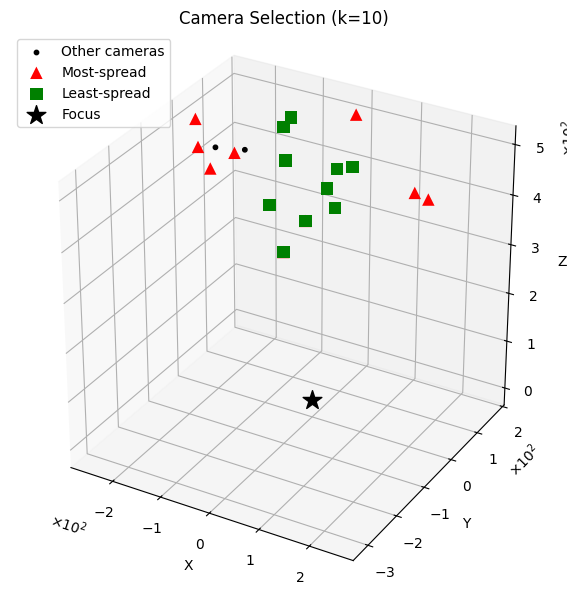

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from itertools import combinations
from matplotlib.ticker import ScalarFormatter

def d_optimal_greedy(camera_positions, focus_point, k):
    rel = camera_positions - focus_point
    u = -rel / np.linalg.norm(rel, axis=1, keepdims=True)
    selected = []
    for _ in range(k):
        best_j, best_det = None, -np.inf
        for j in range(u.shape[0]):
            if j in selected: continue
            F = u[selected + [j]].T @ u[selected + [j]]
            detF = np.linalg.det(F)
            if detF > best_det:
                best_det, best_j = detF, j
        selected.append(best_j)
    return selected

def least_spread_greedy(camera_positions, focus_point, k):
    rel = camera_positions - focus_point
    u   = -rel / np.linalg.norm(rel, axis=1, keepdims=True)
    selected = []
    for _ in range(k):
        worst_j, worst_det = None, np.inf
        for j in range(u.shape[0]):
            if j in selected: continue
            inds = selected + [j]
            F    = u[inds].T @ u[inds]
            detF = np.linalg.det(F)
            if detF < worst_det:
                worst_det, worst_j = detF, j
        selected.append(worst_j)
    return selected

# === Load data ===
df = pd.read_csv(
    "camera_positions.txt",
    comment='#',
    header=None,
    names=['image_id', 'x', 'y', 'z', 'off_nadir', 'azimuth']
)
positions = df[['x', 'y', 'z']].values
focus = np.array([0.0, 0.0, 0.0])
k = 5

# === Compute selections ===
opt_inds = d_optimal_greedy(positions, focus, k)
bad_inds = least_spread_greedy(positions, focus, k)

# === Print out their IDs ===
best_ids = df.loc[opt_inds, 'image_id'].tolist()
worst_ids = df.loc[bad_inds, 'image_id'].tolist()
print("Best-spread camera IDs:", sorted(best_ids))
print("Worst-spread camera IDs:", sorted(worst_ids))

# Convert from meters to kilometers (or whatever unit makes sense)
pos = positions / 1000.0

# Create figure
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# Masks
mask_opt = np.zeros(len(df), bool); mask_opt[opt_inds] = True
mask_bad = np.zeros(len(df), bool); mask_bad[bad_inds] = True
mask_other = ~(mask_opt | mask_bad)

# Plot
ax.scatter(*(pos[mask_other].T),
           marker='o', s=10,
           color='black',   # pick whatever color you like
           alpha=1,             # FULL opacity
           label='Other cameras')

ax.scatter(*(pos[mask_opt].T),
           marker='^', s=80,
           color='red',
           edgecolors='none',
           alpha=1,
           label='Most-spread')

ax.scatter(*(pos[mask_bad].T),
           marker='s', s=80,
           color='green',
           edgecolors='none',
           alpha=1,
           label='Least-spread')

ax.scatter(0,0,0,
           marker='*', s=200,
           color='black',
           alpha=1,
           label='Focus')


# Equal aspect ratio
ax.set_box_aspect((1,1,1))

# Scientific ticks
for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
    axis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

# Labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'Camera Selection (k={k})')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

